# Building an MLJFlux regression model for the Boston house
# price dataset

In [2]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating environment at `~/GoogleDrive/Julia/MLJ/MLJFlux/examples/boston/Project.toml`


**Julia version** is assumed to be 1.6.*

In [3]:
using MLJ
using MLJFlux
using Flux
using Plots

This tutorial uses MLJ's `IteratedModel` wrapper to transform the
MLJFlux `NeuralNetworkRegressor` into a model that **automatically
selects the number of epochs** required to optimize an out-of-sample
loss.

We also show how to include the model in a **pipeline** to carry out
standardization of the features and target.

## Loading data

In [4]:
data = OpenML.load(531); # Loads from https://www.openml.org/d/531

The target `y` is `:MEDV` and everything else except `:CHAS` goes
into the features `X`:

In [5]:
y, X = unpack(data, ==(:MEDV), !=(:CHAS); rng=123);

We specified the seed `rng` to shuffle the observations. The Charles
River dummy variable `:CHAS` is dropped, as not deemed to be
relevant.

Inspecting the scientific types:

In [6]:
scitype(y)

AbstractVector{Continuous} (alias for AbstractArray{Continuous, 1})

In [7]:
schema(X)

┌─────────┬───────────────┬──────────────────────────────────┐
│ names   │ scitypes      │ types                            │
├─────────┼───────────────┼──────────────────────────────────┤
│ CRIM    │ Continuous    │ Float64                          │
│ ZN      │ Continuous    │ Float64                          │
│ INDUS   │ Continuous    │ Float64                          │
│ NOX     │ Continuous    │ Float64                          │
│ RM      │ Continuous    │ Float64                          │
│ AGE     │ Continuous    │ Float64                          │
│ DIS     │ Continuous    │ Float64                          │
│ RAD     │ Multiclass{9} │ CategoricalValue{String, UInt32} │
│ TAX     │ Continuous    │ Float64                          │
│ PTRATIO │ Continuous    │ Float64                          │
│ B       │ Continuous    │ Float64                          │
│ LSTAT   │ Continuous    │ Float64                          │
└─────────┴───────────────┴────────────────────────────

We'll regard `:RAD` (index of accessibility to radial highways) as
`Continuous` as MLJFlux models don't handle ordered factors:

In [8]:
X = coerce(X, :RAD => Continuous);

Let's split off a test set for final testing:

In [9]:
(X, Xtest), (y, ytest) = partition((X, y), 0.7, multi=true);

## Defining a builder

In the macro call below, `n_in` is expected to represent the number
of inputs features and `rng` a RNG (builders are generic, ie can be
applied to data with any number of input features):

In [10]:
builder = MLJFlux.@builder begin
    init=Flux.glorot_uniform(rng)
    Chain(Dense(n_in, 64, relu, init=init),
          Dense(64, 32, relu, init=init),
          Dense(32, 1, init=init))
end

GenericBuilder{#1#2}


## Defining a MLJFlux model:

In [11]:
NeuralNetworkRegressor = @load NeuralNetworkRegressor
    model = NeuralNetworkRegressor(builder=builder,
                                   rng=123,
                                   epochs=20)

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/Ci1zC/src/loading.jl:168


import MLJFlux ✔


NeuralNetworkRegressor(
    builder = GenericBuilder(
            apply = var"#1#2"()),
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}()),
    loss = Flux.Losses.mse,
    epochs = 20,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    rng = 123,
    optimiser_changes_trigger_retraining = false,
    acceleration = CPU1{Nothing}(nothing))

## Standardization

The following wraps our regressor in feature and target standardizations:

In [12]:
pipe = Standardizer |> TransformedTargetModel(model, target=Standardizer)

DeterministicPipeline(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    transformed_target_model_deterministic = TransformedTargetModelDeterministic(
            model = NeuralNetworkRegressor{GenericBuilder{#1#2},…},
            target = Standardizer,
            inverse = nothing,
            cache = true),
    cache = true)

Notice that our original neural network model is now a
hyper-parameter of the composite `pipe`, with the automatically
generated name, `:neural_network_regressor`.

## Choosing a learning rate

Let's see how the training losses look for the default optimiser. For
MLJFlux models, `fit!` will print these losses if we bump the
verbosity level (default is always 1):

In [13]:
mach = machine(pipe, X, y)
fit!(mach, verbosity=2)

┌ Info: Training Machine{DeterministicPipeline{NamedTuple{,…},…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/GxHVg/src/machines.jl:464
┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/GxHVg/src/machines.jl:464
┌ Info: Features standarized: 
└ @ MLJModels /Users/anthony/.julia/packages/MLJModels/Ci1zC/src/builtins/Transformers.jl:825
┌ Info:   :CRIM    mu=3.689791468926554  sigma=8.486186608186063
└ @ MLJModels /Users/anthony/.julia/packages/MLJModels/Ci1zC/src/builtins/Transformers.jl:836
┌ Info:   :ZN    mu=10.392655367231638  sigma=22.078531026900794
└ @ MLJModels /Users/anthony/.julia/packages/MLJModels/Ci1zC/src/builtins/Transformers.jl:836
┌ Info:   :INDUS    mu=11.477372881355933  sigma=6.83192917494762
└ @ MLJModels /Users/anthony/.julia/packages/MLJModels/Ci1zC/src/builtins/Transformers.jl:836
┌ Info:   :NOX    mu=0.5619451977401131  sigma=0.11706875291419269
└ @ MLJModels /Users/anthony/.julia/packages/MLJModels/Ci1zC/src/

Machine{DeterministicPipeline{NamedTuple{,…},…},…} trained 1 time; caches data
  model: MLJBase.DeterministicPipeline{NamedTuple{(:standardizer, :transformed_target_model_deterministic), Tuple{Unsupervised, Deterministic}}, MLJModelInterface.predict}
  args: 
    1:	Source @768 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @147 ⏎ `AbstractVector{Continuous}`


They are also extractable from the training report (which includes
the pre-train loss):

In [14]:
report(mach).transformed_target_model_deterministic.model.training_losses

21-element Vector{Float64}:
 1.2838145640873329
 0.3686760957021546
 0.2215979652158559
 0.17754900774597876
 0.15194120480021098
 0.13221864530853797
 0.11697435053172738
 0.10636408931390769
 0.095208490765527
 0.08948774179997945
 0.08276797005304384
 0.07997044943380421
 0.07726719934689869
 0.07190359246973332
 0.07050712214306228
 0.0669674161856798
 0.06422548257753624
 0.06024360408282619
 0.05974192388977129
 0.05666044439895874
 0.055767894928594526

Next, let's visually compare a few learning rates:

In [15]:
plt = plot()
rates = [5e-5, 1e-4, 0.005, 0.001, 0.05]

5-element Vector{Float64}:
 5.0e-5
 0.0001
 0.005
 0.001
 0.05

By default, changing only the optimiser will not trigger a
cold-restart when we `fit!` (to allow for adaptive learning rate
control). So we call `fit!` with the `force=true`
option. (Alternatively, one can change the hyper-parameter
`pipe.neural_network_regressor.optimiser_changes_trigger_retraining`
to `true`.)

We'll skip the first few losses to get a better vertical scale in
our plot.

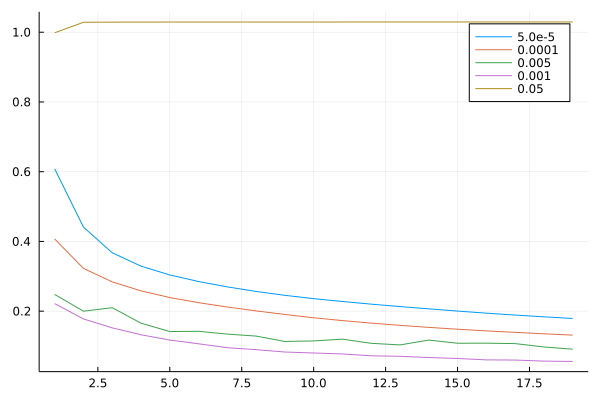

In [16]:
foreach(rates) do η
    pipe.transformed_target_model_deterministic.model.optimiser.eta = η
    fit!(mach, force=true, verbosity=0)
    losses =
        report(mach).transformed_target_model_deterministic.model.training_losses[3:end]
    plot!(1:length(losses), losses, label=η)
end
plt

In [17]:
savefig(joinpath("assets", "learning_rate.png"))

We'll go with the second most conservative rate for now:

In [18]:
pipe.transformed_target_model_deterministic.model.optimiser.eta = 0.0001

0.0001

## Wrapping in iteration control

We want a model that trains until an out-of-sample loss satisfies
the `NumberSinceBest(6)` stopping criterion. We'll add some fallback
stopping criterion `InvalidValue` and `TimeLimit(1/60)`, and
controls to print traces of the losses.

For initializing or clearing the traces:

In [19]:
clear() = begin
    global losses = []
    global training_losses = []
    global epochs = []
    return nothing
end

clear (generic function with 1 method)

And to update the traces:

In [20]:
update_loss(loss) = push!(losses, loss)
update_training_loss(report) =
    push!(training_losses,
          report.transformed_target_model_deterministic.model.training_losses[end])
update_epochs(epoch) = push!(epochs, epoch)

update_epochs (generic function with 1 method)

The controls to apply (see
[here](https://alan-turing-institute.github.io/MLJ.jl/dev/controlling_iterative_models/#Controls-provided)
for the complete list):

In [21]:
controls=[Step(1),
          NumberSinceBest(6),
          InvalidValue(),
          TimeLimit(1/60),
          WithLossDo(update_loss),
          WithReportDo(update_training_loss),
          WithIterationsDo(update_epochs)]

7-element Vector{Any}:
 Step(1)
 NumberSinceBest(6)
 InvalidValue()
 TimeLimit(Dates.Millisecond(60000))
 WithLossDo{typeof(update_loss)}(update_loss, false, nothing)
 WithReportDo{typeof(update_training_loss)}(update_training_loss, false, nothing)
 WithIterationsDo{typeof(update_epochs)}(update_epochs, false, nothing)

Next we create a "self-iterating" version of the pipeline. Note
that the iteration parameter is a nested hyperparameter:

In [22]:
iterated_pipe =
    IteratedModel(model=pipe,
                  controls=controls,
                  resampling=Holdout(fraction_train=0.8),
                  iteration_parameter=:(neural_network_regressor.epochs),
                  measure = l2)

DeterministicIteratedModel(
    model = DeterministicPipeline(
            standardizer = Standardizer,
            transformed_target_model_deterministic = TransformedTargetModelDeterministic{NeuralNetworkRegressor{GenericBuilder{#1#2},…}},
            cache = true),
    controls = Any[Step(1), NumberSinceBest(6), InvalidValue(), TimeLimit(Dates.Millisecond(60000)), WithLossDo{typeof(update_loss)}(update_loss, false, nothing), WithReportDo{typeof(update_training_loss)}(update_training_loss, false, nothing), WithIterationsDo{typeof(update_epochs)}(update_epochs, false, nothing)],
    resampling = Holdout(
            fraction_train = 0.8,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = LPLoss(p = 2),
    weights = nothing,
    class_weights = nothing,
    operation = MLJModelInterface.predict,
    retrain = false,
    check_measure = true,
    iteration_parameter = :(neural_network_regressor.epochs),
    cache = true)

Training the wrapped model on all the train/validation data:

In [23]:
clear()
mach = machine(iterated_pipe, X, y)
fit!(mach)

┌ Info: Training Machine{DeterministicIteratedModel{DeterministicPipeline{NamedTuple{,…},…}},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/GxHVg/src/machines.jl:464
┌ Info: final loss: 18.029846309038444
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/lO4bA/src/train.jl:44
┌ Info: final training loss: 0.15870439154333713
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/lO4bA/src/train.jl:46
┌ Info: Stop triggered by NumberSinceBest(6) stopping criterion. 
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/lO4bA/src/stopping_controls.jl:54
┌ Info: Total of 13 iterations. 
└ @ MLJIteration /Users/anthony/.julia/packages/MLJIteration/jtWxG/src/core.jl:35


Machine{DeterministicIteratedModel{DeterministicPipeline{NamedTuple{,…},…}},…} trained 1 time; does not cache data
  model: MLJIteration.DeterministicIteratedModel{MLJBase.DeterministicPipeline{NamedTuple{(:standardizer, :transformed_target_model_deterministic), Tuple{Unsupervised, Deterministic}}, MLJModelInterface.predict}}
  args: 
    1:	Source @623 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @109 ⏎ `AbstractVector{Continuous}`


And plotting the traces:

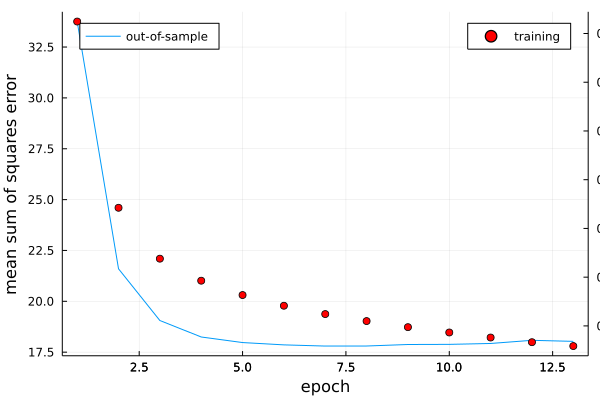

In [24]:
plot(epochs, losses,
     xlab = "epoch",
     ylab = "mean sum of squares error",
     label="out-of-sample",
     legend = :topleft);
scatter!(twinx(), epochs, training_losses, label="training", color=:red)

In [25]:
savefig(joinpath("assets", "loss.png"))

**How `IteratedModel` works.** Training an `IteratedModel` means
holding out some data (80% in this case) so an out-of-sample loss
can be tracked and used in the specified stopping criterion,
`NumberSinceBest(4)`. However, once the stop is triggered, the model
wrapped by `IteratedModel` (our pipeline model) is retrained on all
data for the same number of iterations. Calling `predict(mach,
Xnew)` on new data uses the updated learned parameters.

In other words, `iterated_model` is a "self-iterating" version of
the original model, where `epochs` has been transformed from
hyper-parameter to *learned* parameter.

## An evaluation of the self-iterating model

Here's an estimate of performance of our "self-iterating"
model:

In [26]:
e = evaluate!(mach,
              resampling=CV(nfolds=8),
              measures=[l1, l2])

Evaluating over 8 folds: 100%[=========================] Time: 0:00:12


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌───────────────┬─────────────┬───────────┬─────────────────────────────────────
│ measure       │ measurement │ operation │ per_fold                           ⋯
├───────────────┼─────────────┼───────────┼─────────────────────────────────────
│ LPLoss(p = 1) │ 2.64        │ predict   │ [2.38, 2.8, 2.96, 2.89, 1.81, 2.43 ⋯
│ LPLoss(p = 2) │ 17.8        │ predict   │ [19.8, 24.4, 26.6, 14.4, 6.1, 10.6 ⋯
└───────────────┴─────────────┴───────────┴─────────────────────────────────────
                                                                1 column omitted


In [27]:
using Measurements
l1_loss = e.measurement[1] ± std(e.per_fold[1])/sqrt(7)
@show l1_loss

l1_loss = 2.64 ± 0.17


2.64 ± 0.17

We take this estimate of the uncertainty of the generalization error with a [grain of salt](https://direct.mit.edu/neco/article-abstract/10/7/1895/6224/Approximate-Statistical-Tests-for-Comparing)).

## Comparison with other models on the test set

Although we cannot assign them statistical significance, here are
comparisons, on the untouched test set, of the eror of our
self-iterating neural network regressor with a couple of other
models trained on the same data (using default hyperparameters):

In [28]:
function performance(model)
    mach = machine(model, X, y) |> fit!
    yhat = predict(mach, Xtest)
    l1(yhat, ytest) |> mean
end
performance(iterated_pipe)

three_models = [(@load EvoTreeRegressor)(), # tree boosting model
                (@load LinearRegressor pkg=MLJLinearModels)(),
                iterated_pipe]

errs = performance.(three_models)

(models=MLJ.name.(three_models), mean_square_errors=errs) |> pretty

┌ Info: Training Machine{DeterministicIteratedModel{DeterministicPipeline{NamedTuple{,…},…}},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/GxHVg/src/machines.jl:464
┌ Info: final loss: 18.029846309038444
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/lO4bA/src/train.jl:44
┌ Info: final training loss: 0.15870439154333713
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/lO4bA/src/train.jl:46
┌ Info: Stop triggered by NumberSinceBest(6) stopping criterion. 
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/lO4bA/src/stopping_controls.jl:54
┌ Info: Total of 13 iterations. 
└ @ MLJIteration /Users/anthony/.julia/packages/MLJIteration/jtWxG/src/core.jl:35


import EvoTrees ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/Ci1zC/src/loading.jl:168


import MLJLinearModels ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/Ci1zC/src/loading.jl:168


┌ Info: Training Machine{EvoTreeRegressor{Float64,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/GxHVg/src/machines.jl:464
┌ Info: Training Machine{LinearRegressor,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/GxHVg/src/machines.jl:464
┌ Info: Training Machine{DeterministicIteratedModel{DeterministicPipeline{NamedTuple{,…},…}},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/GxHVg/src/machines.jl:464
┌ Info: final loss: 18.029846309038444
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/lO4bA/src/train.jl:44
┌ Info: final training loss: 0.15870439154333713
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/lO4bA/src/train.jl:46
┌ Info: Stop triggered by NumberSinceBest(6) stopping criterion. 
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/lO4bA/src/stopping_controls.jl:54
┌ Info: Total of 13 iterations. 
└ @ MLJIteration /Users/anthony/.julia/packages/MLJIteration/jtWxG/src/core.jl:35


┌────────────────────────────┬────────────────────┐
│ models                     │ mean_square_errors │
│ String                     │ Float64            │
│ Textual                    │ Continuous         │
├────────────────────────────┼────────────────────┤
│ EvoTreeRegressor           │ 3.59326            │
│ LinearRegressor            │ 3.56423            │
│ DeterministicIteratedModel │ 2.7276             │
└────────────────────────────┴────────────────────┘


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*